In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

In [23]:
edgelist=[]

with open(r"C:\Users\rishi\ml_projects\SBGNN\senate1to10_cikm2019_balance_in_signed_bipartite_networks.txt") as f:
        for ind, line in enumerate(f):
            if ind == 0: 
                na,nb,ns=map(int, line.split('\t'))
                set_b=[f"set_b_{i}" for i in range(0,nb)]
                set_a=[f"set_a_{i}" for i in range(0,na)]
                continue
            a, b, s = map(int, line.split('\t'))
            if s==1:
                edgelist.append((f"set_a_{a}",f"set_b_{b}",{'sign' :'+1' }))
            else:
                 edgelist.append((f"set_a_{a}",f"set_b_{b}",{'sign' :'-1' }))

B = nx.Graph()
B.add_nodes_from(set_a, bipartite=0)
B.add_nodes_from(set_b, bipartite=1)
B.add_edges_from(edgelist)

In [24]:
import matplotlib.pyplot as plt
colors = ['yellow' for _ in set_a] + ['green' for _ in set_b]
print(len(colors))
print(len(set_a))
print(len(set_b))
node_list=["bill_100","sen_100"]
# Draw the graph
num_nodes = B.number_of_nodes()

print("Number of nodes in the graph:", num_nodes)

1201
145
1056
Number of nodes in the graph: 1201


In [25]:
edge_colors = []
for u, v, attrs in B.edges(data=True):
    if attrs['sign'] == '+1':
        edge_colors.append('blue')   # Positive sign color
    else:
        edge_colors.append('red') 

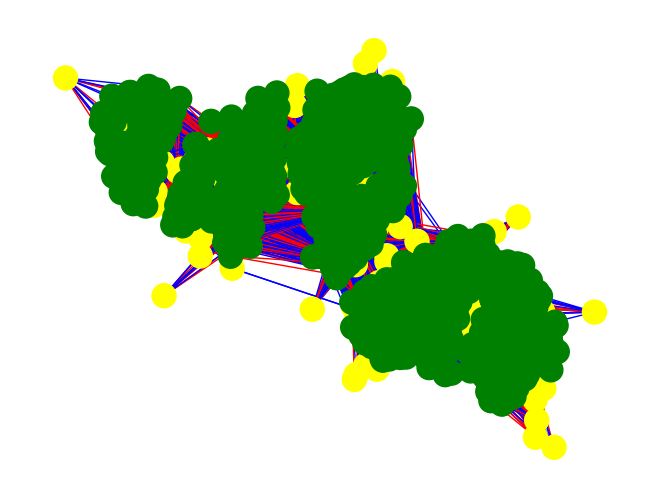

In [26]:
nx.draw(B, with_labels=False,node_color=colors,edge_color=edge_colors)
plt.show()

In [27]:
print(B.edges)


[('set_a_0', 'set_b_727'), ('set_a_0', 'set_b_728'), ('set_a_0', 'set_b_734'), ('set_a_0', 'set_b_735'), ('set_a_0', 'set_b_736'), ('set_a_0', 'set_b_737'), ('set_a_0', 'set_b_738'), ('set_a_0', 'set_b_739'), ('set_a_0', 'set_b_743'), ('set_a_0', 'set_b_757'), ('set_a_0', 'set_b_765'), ('set_a_0', 'set_b_776'), ('set_a_0', 'set_b_781'), ('set_a_0', 'set_b_782'), ('set_a_0', 'set_b_787'), ('set_a_0', 'set_b_794'), ('set_a_0', 'set_b_798'), ('set_a_0', 'set_b_801'), ('set_a_0', 'set_b_809'), ('set_a_0', 'set_b_820'), ('set_a_1', 'set_b_420'), ('set_a_1', 'set_b_421'), ('set_a_1', 'set_b_422'), ('set_a_1', 'set_b_423'), ('set_a_1', 'set_b_425'), ('set_a_1', 'set_b_426'), ('set_a_1', 'set_b_427'), ('set_a_1', 'set_b_428'), ('set_a_1', 'set_b_429'), ('set_a_1', 'set_b_430'), ('set_a_1', 'set_b_431'), ('set_a_1', 'set_b_432'), ('set_a_1', 'set_b_433'), ('set_a_1', 'set_b_434'), ('set_a_1', 'set_b_435'), ('set_a_1', 'set_b_436'), ('set_a_1', 'set_b_437'), ('set_a_1', 'set_b_438'), ('set_a_1',

In [28]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.4):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)   # Fully connected layer
        self.dropout = nn.Dropout(p=dropout_prob)    # Dropout layer
        self.output_layer = nn.Linear(output_dim, output_dim)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))    # Apply ReLU activation to the fully connected layer
        x = self.dropout(x)        # Apply dropout to the output of the fully connected layer
        x = self.output_layer(x)   # Output layer, no activation function
        return x

In [35]:
class SBGNN(nn.Module):
    def __init__(self, graph):
        super(SBGNN, self).__init__()

        self.graph = graph
        self.set_a=[n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 0]
        self.set_b=[n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 1]

        self.emb_dim_a = 32
        self.emb_dim_b = 32

        self.features_a = {node:nn.Embedding(1,self.emb_dim_a) for node in self.set_a}
        self.features_b = {node:nn.Embedding(1,self.emb_dim_b) for node in self.set_b}
        

        self.weight_a_b = nn.Parameter(torch.randn(self.emb_dim_a,self.emb_dim_a))
        self.weight_a_u = nn.Parameter(torch.randn(self.emb_dim_a,self.emb_dim_a))
        self.weight_b_b = nn.Parameter(torch.randn(self.emb_dim_b,self.emb_dim_b))
        self.weight_b_u = nn.Parameter(torch.randn(self.emb_dim_b,self.emb_dim_b))

        self.mlp_a=MLP(3*self.emb_dim_a,self.emb_dim_a)
        self.mlp_b=MLP(3*self.emb_dim_b,self.emb_dim_b)

    def message_passing(self, iterations=1):

        for i in range(iterations):
            new_features_a_b={node: torch.zeros(self.emb_dim_a) for node in self.set_a}
            new_features_a_u={node: torch.zeros(self.emb_dim_a) for node in self.set_a}
            new_features_b_b={node: torch.zeros(self.emb_dim_a) for node in self.set_b}
            new_features_b_u={node: torch.zeros(self.emb_dim_a) for node in self.set_b}
            new_features_a={node: torch.zeros(self.emb_dim_a) for node in self.set_a}
            new_features_b={node: torch.zeros(self.emb_dim_b) for node in self.set_b}


            for node in self.set_a:
            # Aggregate messages from neighbors
                count_b=0
                count_u=0
                for neighbor in self.graph.neighbors(node):
                    sign = self.graph.edges[node, neighbor]['sign']
                    if sign == '+1':
                        new_features_a_b[node]+=self.features_b[neighbor].weight.squeeze()
                        count_b+=1
                    else:
                        new_features_a_u[node]+=self.features_b[neighbor].weight.squeeze()
                        count_u+=1

                if(count_b>0):
                    new_features_a_b[node]/=count_b
                    new_features_a_b[node]=torch.matmul(new_features_a_b[node],self.weight_a_b)
                if(count_u>0):
                    new_features_a_u[node]/=count_u
                    new_features_a_u[node]=torch.matmul(new_features_a_u[node],self.weight_a_u)


                new_features_a[node]=torch.cat((new_features_a_b[node],new_features_a_u[node],self.features_a[node].weight.squeeze()),dim=0)

                new_features_a[node]=self.mlp_a(new_features_a[node])

            for node in self.set_b:
            # Aggregate messages from neighbors
                count_b=0
                count_u=0
                for neighbor in self.graph.neighbors(node):
                    sign = self.graph.edges[node, neighbor]['sign']
                    if sign == '+1':
                        new_features_b_b[node]+=self.features_a[neighbor].weight.squeeze()
                        count_b+=1
                    else:
                        new_features_b_u[node]+=self.features_a[neighbor].weight.squeeze()
                        count_u+=1
                if(count_b>0):
                    new_features_b_b[node]/=count_b
                    new_features_b_b[node]=torch.matmul(new_features_b_b[node],self.weight_b_b)
                if(count_u>0):
                    new_features_b_u[node]/=count_u
                    new_features_b_u[node]=torch.matmul(new_features_b_u[node],self.weight_b_u)


                new_features_b[node]=torch.cat((new_features_b_b[node],new_features_b_u[node],self.features_b[node].weight.squeeze()),dim=0)

                new_features_b[node]=self.mlp_b(new_features_b[node])
                

            self.features_a=new_features_a
            self.features_b=new_features_b
            

In [36]:
sbgnn = SBGNN(B)
sbgnn.message_passing(iterations=1)